# Задание 4

## Формулировка

1. *Элементарный перцептрон. Ансамбль элементарных перцептронов*

  Проведите обучение и классификацию рукописных символов MNIST с помощью ансамбля элементарных перцептронов. Для ускорения обучения выберите часть выборки MNIST, соответствующую цифрам, некоторым буквам и т.д.

2. *Многослойный перцептрон (МСП)*

  Получите МСП-регрессор, дающий отображение $МСП(w, x): \mathbb{R} \rightarrow \mathbb{R}$. Для этого модифицируйте модель:

  + Размер входа МСП равен 1
  + Сигмоидальный выходной слой отсутсвует
  + Размер выхода равен 1
  + Функция ошибки - сумма квадратов ошибок (MSE)

  Проведите обучение на тех же выборках, которые использовались для полиномиальной регрессии, и сравните полученные результаты. Получите переобучение.

## Реализация элементарного перцептрона

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class Perceptron(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layers = nn.Linear(input_size, output_size, dtype=torch.float64)

    def forward(self, X):
        pred = self.layers(X)
        return torch.softmax(pred, dim=1)

    def fit(self, X: torch.Tensor, Y: torch.Tensor, epoch, batch_size, lr):
        N = X.shape[0]
        X = X.type(torch.float64)

        optimizer = optim.SGD(self.parameters(), lr=lr)
        criterion = nn.MSELoss()

        for i in range(epoch):
            indices = torch.randperm(N)
            X, Y = X[indices], Y[indices]
            for j in range(0, N - batch_size, batch_size):
                X_batch, Y_batch = X[j:j+batch_size], Y[j:j+batch_size]
                self.layers.zero_grad()
                Y_pred = self(X_batch)
                loss = criterion(Y_pred, Y_batch)
                loss.backward()
                optimizer.step()

    def predict(self, X):
        X = X.type(torch.float64)
        pred = self(X)
        return torch.argmax(pred, dim=1)

## Реализация ансамбля моделей

In [ ]:
class Ensemble:
    def __init__(self, models, output_size, train_size):
        self.output_size = output_size
        self.train_size = train_size
        self.models = models

    def fit(self, X: torch.Tensor, Y: torch.Tensor, epoch, batch_size, lr):
        N = X.shape[0]
        n = int(self.train_size * N)
        for model in self.models:
            indices = torch.randperm(N)
            model.fit(X[indices[:n]], Y[indices[:n]], epoch, batch_size, lr)

    def predict(self, X):
        X = X.type(torch.float64)
        preds = torch.zeros((X.shape[0], self.output_size))
        for model in self.models:
            pred = model(X)
            preds += pred
        return torch.argmax(preds, dim=1)

## Обучение на выборках MNIST

+ Добавить функции для отрисовки результатов:

In [ ]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score

def draw_sample(X, Y, num_images_to_show=5):
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(30, 12))
    pil = ToPILImage()
    for i in range(num_images_to_show):
        image, label = X[i], Y[i]
        image = pil(image.reshape(28, 28))
        axes[i].imshow(image, cmap='inferno')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

def draw_heatmap(y_pred, y_true):
    with torch.no_grad():
        matrix = confusion_matrix(y_true, y_pred)
        ConfusionMatrixDisplay(matrix, display_labels=range(10)).plot(
            include_values=True, cmap='Blues')

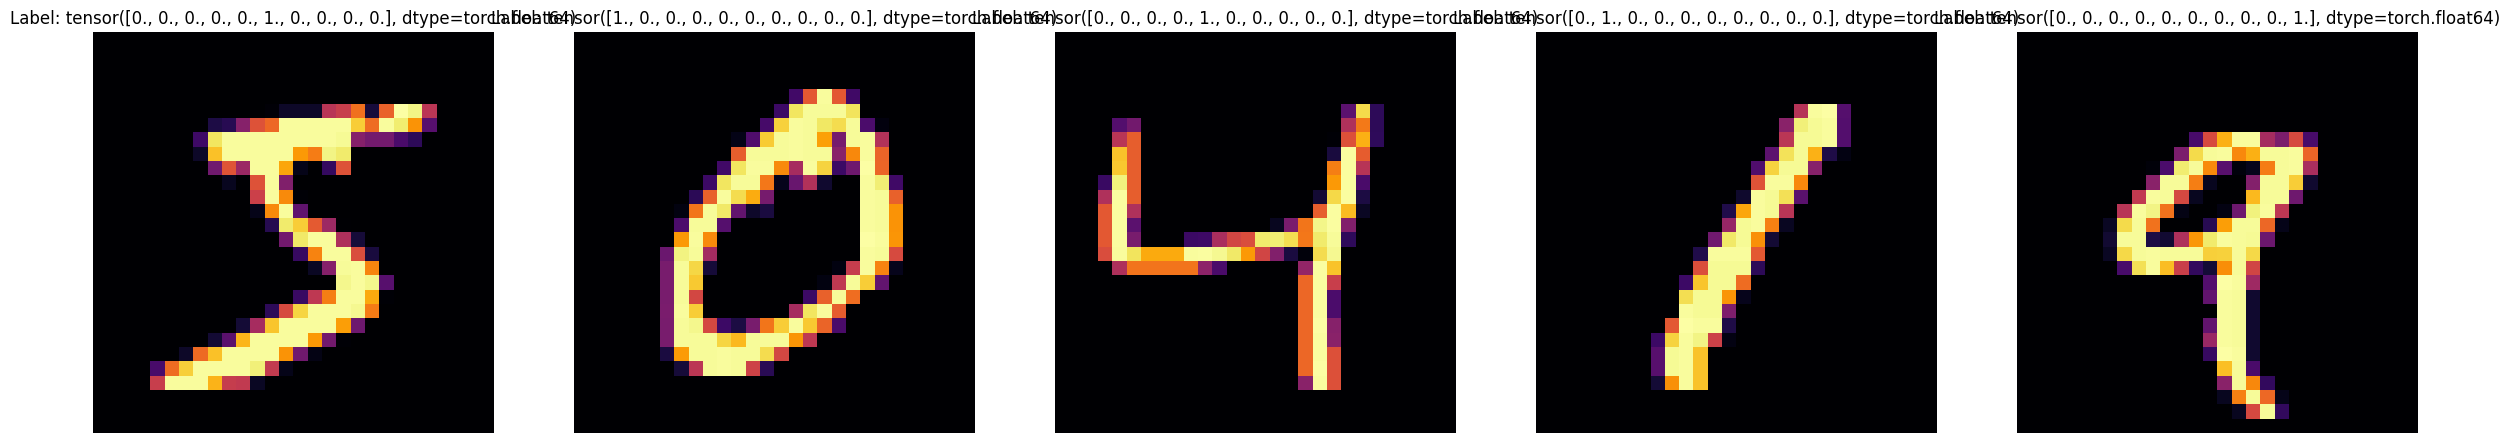

Accuracy: 0.9003


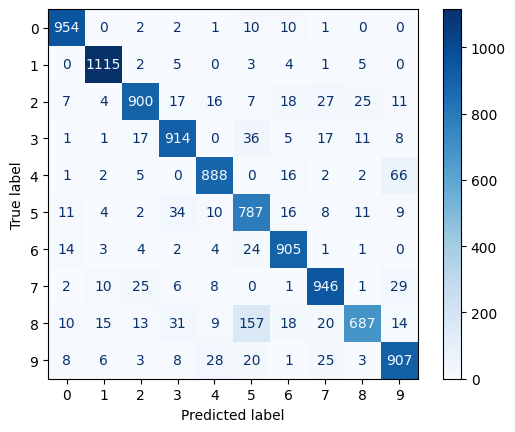

In [ ]:
import torchvision.datasets.mnist as mnist
import torchvision.transforms as trnsfrms

transform = trnsfrms.Compose([
    trnsfrms.ToTensor()
])

full_train_set =  mnist.MNIST('./data', download=True, train=True, transform=transform)
full_test_set = mnist.MNIST('./data', download=True, train=False, transform=transform)
full_train_x, full_train_y = full_train_set.data.reshape(-1, 28*28), full_train_set.targets
full_test_x, full_test_y = full_test_set.data.reshape(-1, 28*28), full_test_set.targets

digit_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
train_ind = [i for i, label in enumerate(full_train_y) if label in digit_labels]
test_ind = [i for i, label in enumerate(full_test_y) if label in digit_labels]

dig_train_x, dig_train_y = full_train_x[train_ind], full_train_y[train_ind]
dig_test_x, dig_test_y = full_test_x[test_ind], full_test_y[test_ind]

dig_train_y_encoded = torch.zeros(dig_train_y.shape[0], 10, dtype=torch.float64)
dig_train_y_encoded[torch.arange(dig_train_y.shape[0]), dig_train_y] = 1

dig_test_y_encoded = torch.zeros(dig_test_y.shape[0], 10, dtype=torch.float64)
dig_test_y_encoded[torch.arange(dig_test_y.shape[0]), dig_test_y] = 1
draw_sample(dig_train_x, dig_train_y_encoded)


models = [Perceptron(28*28, 10) for _ in range(10)]
ensemble = Ensemble(models, 10, 0.8)
ensemble.fit(dig_train_x, dig_train_y_encoded, 10, 100, 0.003)
dig_test_pred = ensemble.predict(dig_test_x)

print(f'Accuracy: {accuracy_score(dig_test_y, dig_test_pred)}')
draw_heatmap(dig_test_pred, dig_test_y)

## Реализация многослойного перцептрона

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, hidden_layers_num=3, neyrons_num=5, activation_func=nn.ReLU):
        super().__init__()
        hidden_layers = []
        for i in range(hidden_layers_num-1):
            hidden_layers.append(nn.Linear(neyrons_num, neyrons_num, dtype=torch.float64))
            hidden_layers.append(activation_func())
        self.model = nn.Sequential(
            nn.Linear(1, neyrons_num, dtype=torch.float64),
            activation_func(),
            *hidden_layers,
            nn.Linear(neyrons_num, 1, dtype=torch.float64),
        )

    def forward(self, x):
        return self.model(x)

    def fit(self, X: torch.Tensor, Y: torch.Tensor, epochs=3000, batch_size=32, lr=0.03, logs=False):
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)

        for epoch in range(epochs):
            self.model.train()
            indices = torch.randperm(X.shape[0])
            x, y = X[indices], Y[indices]
            for i in range(0, X.shape[0], batch_size):
                x_batch, y_batch = x[i:i+batch_size], y[i:i+batch_size]

                outputs = self.model(x_batch)
                loss = self.criterion(outputs, y_batch)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            if logs:
              print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

    def predict(self, X):
        self.model.eval()
        return self.forward(X)

## Получение регрессора

+ Добавить функцию для отображение результата:

In [50]:
import matplotlib.pyplot as plt


def draw_polinom_regression(x1, y1, x2, y2, xx, yy, title):
    plt.scatter(xx, yy, color="blue")
    plt.plot(x1, y1, color="green")
    plt.plot(x2, y2, color="red")

    plt.ylim(y1.min() - 1, y1.max() + 1)
    plt.title(title)
    plt.show()

+ Сгенерировать параметры полинома и выборку:

In [62]:
import numpy as np

a, b, c, d = np.random.uniform(low=-3, high=3, size=4)
x1 = np.linspace(-1, 1, 1000)
y1 = a * x1**3 + b * x1**2 + c * x1 + d

N = 20
xx = np.random.uniform(low=-1, high=1, size=N)
yy = a * xx**3 + b * xx**2 + c * xx + d + np.random.normal(0, 0.5, N)

x2 = np.linspace(-1, 1, 10000)

+ Тестирование с $num\_of\_layers=3, neyrons\_num=5$

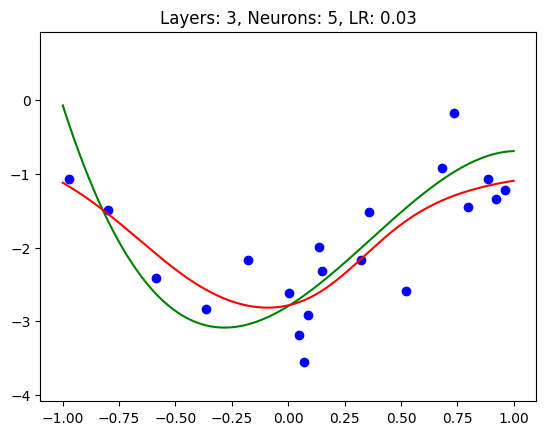

In [63]:
num_of_layers=3
neyrons_num=5
lr=0.03
activation_func=nn.Tanh

mlp = MLP(num_of_layers, neyrons_num, activation_func)
mlp.fit(torch.tensor(xx).reshape(-1, 1), torch.tensor(yy).reshape(-1, 1), batch_size=16, epochs=1000, lr=lr)
y2 = mlp.predict(torch.tensor(x2).reshape(-1, 1)).detach().numpy()

draw_polinom_regression(x1, y1, x2, y2, xx, yy, f'Layers: {num_of_layers}, Neurons: {neyrons_num}, LR: {lr}')

+ Тестирование с $num\_of\_layers=6, neyrons\_num=10, lr=0.03$

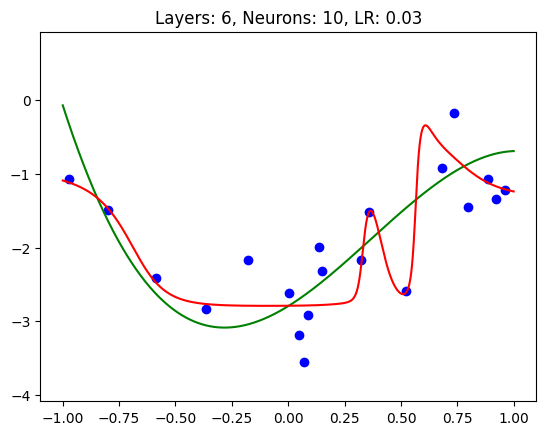

In [64]:
num_of_layers=6
neyrons_num=10
lr=0.03
activation_func=nn.Tanh

mlp = MLP(num_of_layers, neyrons_num, activation_func)
mlp.fit(torch.tensor(xx).reshape(-1, 1), torch.tensor(yy).reshape(-1, 1), batch_size=16, epochs=10000, lr=lr)
y2 = mlp.predict(torch.tensor(x2).reshape(-1, 1)).detach().numpy()

draw_polinom_regression(x1, y1, x2, y2, xx, yy, f'Layers: {num_of_layers}, Neurons: {neyrons_num}, LR: {lr}')